# **Quantum Furrier Transform**
#### The Quantum Fourier Transform (QFT) is the quantum analogue of the classical discrete Fourier transform (DFT). The QFT essentially maps each basis state to a superposition of all basis states weighted by the Fourier coefficients.
#### For a quantum state $|x\rangle$, where $x$ is an integer encoded in binary from $0$ to $2^n-1$ for $n$ qubits the QFT converts $|x\rangle$ into a superposition of all possible basis states $|y\rangle$, with each term weighted by a phase factor determined by the input:
$$
|x\rangle \rightarrow \frac{1}{2^n}\sum_{y = 0}^{2^n-1}e^{\frac{2\pi i x y}{2^n}}|y\rangle
$$


In [49]:
from numpy import pi
from qiskit import QuantumCircuit
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram , plot_bloch_multivector



#### To construct a quantum circuit for QFT, we should apply combination of Hadamard gates and controlled phase rotation gates. Here's how the circuit is typically structured for $n$ qubits.
## **Step 1:** Apply Hadamard gate on the last qubit
#### We apply the Hadamard gate on the $n$th qubit to create a superposition. As an example for $n =3$ qubits the state after applying the Hadamard gate becomes:
$$
|\phi_1\rangle = \left(H_3|x_3\rangle\right) |x_2x_1\rangle\nonumber\\
=\frac{1}{\sqrt{2}} \big[|0\rangle + e^{(2\pi i/2)x_3}|1\rangle\big]|x_2x_1\rangle.
$$

## **Step 2:** Apply controlled phase rotation gates
#### Now we should apply $n-1$ controlled phase rotation gates for all previous qubits where the $n$th qubits is the gate target. This adds a phase shift depending on the state of the other qubits. These rotations are of the form $R_k = e^{2\pi i/2^k}$ where $k$ is the number of qubits involved in the control. For $n =3$ we have:
$$
|\phi_2\rangle = R_3|\phi_1\rangle\nonumber\\
=\frac{1}{\sqrt{2}} \big[|0\rangle + e^{\big\{(2\pi i/{2*3})x_1 + (2\pi i/2)x_3\big\}}|1\rangle\big]|x_2x_1\rangle.
$$
and 
$$
|\phi_3\rangle = R_2|\phi_2\rangle\nonumber\\
=\frac{1}{\sqrt{2}} \big[|0\rangle + e^{\big\{(2\pi i/{2^3})x_1 + (2\pi i/{2^2})x_2 + (2\pi i/2)x_3\big\}}|1\rangle\big]|x_2x_1\rangle.
$$
#### The steps 1 and 2 are repeated for the other qubits respectively. 
#### For $n = 3$, first we repeat the steps 1 and 2 to the 2nd qubit by applying the Hadamard gate $H_2$ and controlled phase rotation $R_2$:
$$
|\phi_4\rangle = H_2|\phi_3\rangle\nonumber\\
=\frac{1}{\sqrt{2}} \big[|0\rangle + e^{\big\{(2\pi i/{2^3})x_1 + (2\pi i/{2^2})x_2 + (2\pi i/2)x_3\big\}}|1\rangle\big]\frac{1}{\sqrt{2}} \big[|0\rangle + e^{(2\pi i/2)x_2}|1\rangle\big]|x_1\rangle.
$$
and 
$$
|\phi_5\rangle = R_2|\phi_4\rangle\nonumber\\
=\frac{1}{\sqrt{2}} \big[|0\rangle + e^{\big\{(2\pi i/{2^3})x_1 + (2\pi i/{2^2})x_2 + (2\pi i/2)x_3\big\}}|1\rangle\big]\frac{1}{\sqrt{2}} \big[|0\rangle + e^{(2\pi i/2)x_2 + (2\pi i/2^2)x_1}|1\rangle\big]|x_1\rangle.
$$
#### At the end, we apply the Hadamard gate $H_1$ to the 1rst qubit:
$$
|\phi_6\rangle = H_1|\phi_5\rangle\nonumber\\
=\frac{1}{\sqrt{2}} \big[|0\rangle + e^{\big\{(2\pi i/{2^3})x_1 + (2\pi i/{2^2})x_2 + (2\pi i/2)x_3\big\}}|1\rangle\big]\frac{1}{\sqrt{2}} \big[|0\rangle + e^{(2\pi i/2)x_2 + (2\pi i/2^2)x_1}|1\rangle\big]\frac{1}{\sqrt{2}} \big[|0\rangle + e^{(2\pi i/2)x_1}|1\rangle\big].
$$
## **Step 3:** Apply swap gate 
#### In the final step we reverse the order of the qubits using a swap gate. This is necessary because the QFT is essentially a bit-reversed operation. For $n = 3$ we reverse the order of the qubits 1 and 3:
$$
|\phi_7\rangle =\frac{1}{\sqrt{2}} \big[|0\rangle + e^{(2\pi i/2)x_1}|1\rangle\big]\frac{1}{\sqrt{2}} \big[|0\rangle + e^{(2\pi i/2)x_2 + (2\pi i/2^2)x_1}|1\rangle\big]\frac{1}{\sqrt{2}} \big[|0\rangle + e^{\big\{(2\pi i/{2^3})x_1 + (2\pi i/{2^2})x_2 + (2\pi i/2)x_3\big\}}|1\rangle\big].
$$

#### In the following, we define functions for each step and then structure the QFT circuit for $n = 3$ with two different initial states $|000\rangle$ and $|101\rangle$. 


In [7]:
# function for the rotation part of the QFT 
def qft_rotations(circuit , n):
    if n == 0:
        return circuit
    n -= 1 # the range of qubits is (0, n-1)
    circuit.h(n) # apply Hadamard gate to the last qubit   
    for qubit in range(n):
        circuit.cp(pi/2**(n-qubit), qubit , n) # in each cp gate the all qubits smaller than n become control respectively and the nth qubit is target for them.
    
   
    qft_rotations(circuit , n)

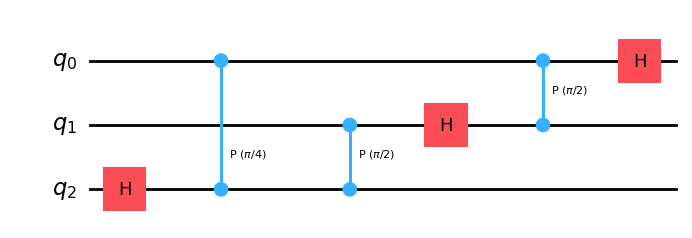

In [8]:
qc = QuantumCircuit(3)

qft_rotations(qc, 3)
qc.draw('mpl')

In [12]:
# Function for the swap part of QFT
def swap_registers(circuit , n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

In [13]:
# Function for QFT 
def qft(circuit , n):
    qft_rotations(circuit, n)
    swap_registers(circuit , n)
    return circuit

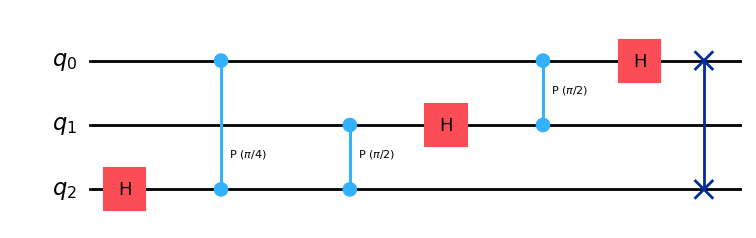

In [15]:
qc = QuantumCircuit(3)
qft(qc, 3)
qc.draw('mpl')


 Quantum state is: Statevector([0.354+0.j, 0.354+0.j, 0.354+0.j, 0.354+0.j, 0.354+0.j,
             0.354+0.j, 0.354+0.j, 0.354+0.j],
            dims=(2, 2, 2))


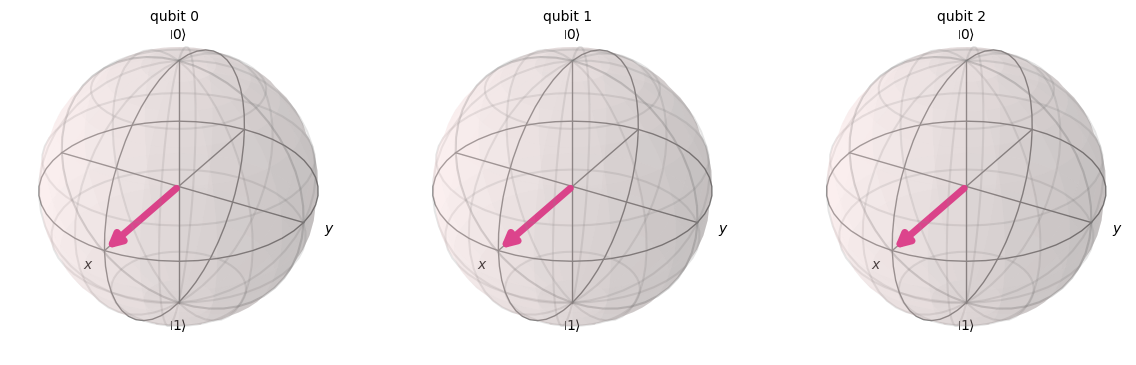

In [16]:
# initiate
estimator = Aer.get_backend('statevector_simulator')

#run
job = estimator.run(qc)

# result
psi = job.result().get_statevector(qc, decimals = 3)

print("\n Quantum state is:" , psi)

plot_bloch_multivector(psi)

#### The Bloch visualization shows that the QFT of $|000\rangle$ is $|+++\rangle$ where $|+\rangle = \frac{1}{\sqrt{2}} \big[|0\rangle + |1\rangle\big]$, in agreement with the mathematical relation for $|\phi_7\rangle$.

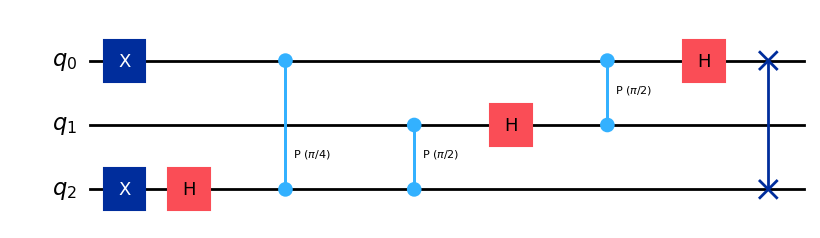

In [17]:
# qft for |101> initial state
qc = QuantumCircuit(3)
qc.x(0)
qc.x(2)
qft(qc, 3)
qc.draw('mpl')


 Quantum state is: Statevector([ 0.354-0.j   , -0.25 -0.25j ,  0.   +0.354j,  0.25 -0.25j ,
             -0.354+0.j   ,  0.25 +0.25j , -0.   -0.354j, -0.25 +0.25j ],
            dims=(2, 2, 2))


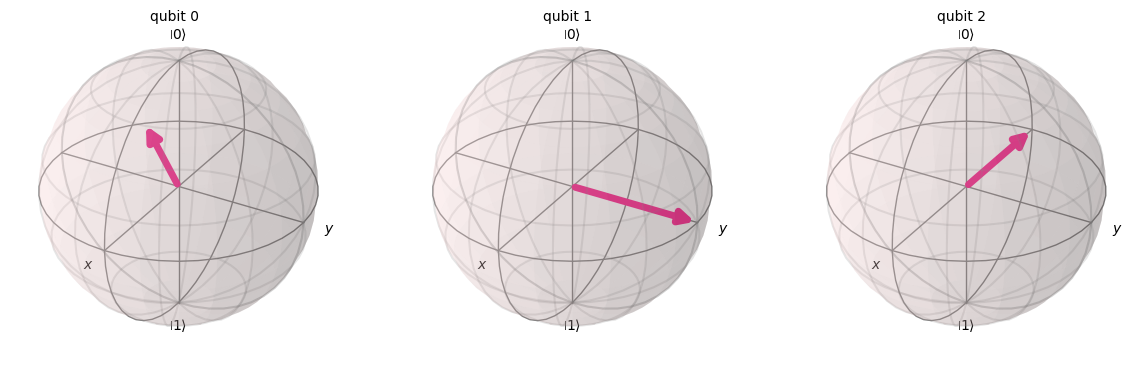

In [18]:
# initiate
estimator = Aer.get_backend('statevector_simulator')

#run
job = estimator.run(qc)

# result
psi = job.result().get_statevector(qc, decimals = 3)

print("\n Quantum state is:" , psi)

plot_bloch_multivector(psi)

#### According to this result, the QFT of $|101\rangle$ is $\frac{1}{\sqrt{2}} \big[|0\rangle - |1\rangle\big]\frac{1}{\sqrt{2}} \big[|0\rangle -i |1\rangle\big]\frac{1}{\sqrt{2}} \big[|0\rangle - e^{(i\pi/4)} |1\rangle\big]$, also in agreement with relation for $|\phi_7\rangle$.

## Obtain the computational basis using inverse QFT
#### If the inverse of QFT is applied to Furrier transform basis, we can reach back the initial computational basis.

In [44]:
# Inverse function: get the computational basis from the Fourier Tranform basis
def inverse_qft(circuit, n):
    qft_circ = qft(QuantumCircuit(n), n)
    invqft_circ = qft_circ.inverse()
    circuit.append(invqft_circ, circuit.qubits[:n])
    return circuit.decompose() # .decompose() allows us to see the individual gates


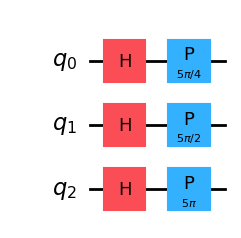

In [45]:
# Manually create the states equvalent to the QFT of |101> state
nqubits = 3
number = 5
qc = QuantumCircuit(nqubits)
for qubit in range(nqubits):
    qc.h(qubit)
qc.p(number * pi/4 , 0) # the 1st qubit
qc.p(number * pi/2 , 1) #  the 2nd qubit
qc.p(number * pi , 2) # the 3rd qubit
qc.draw('mpl')


 Quantum state is: Statevector([ 0.354+0.j   , -0.25 -0.25j ,  0.   +0.354j,  0.25 -0.25j ,
             -0.354+0.j   ,  0.25 +0.25j , -0.   -0.354j, -0.25 +0.25j ],
            dims=(2, 2, 2))


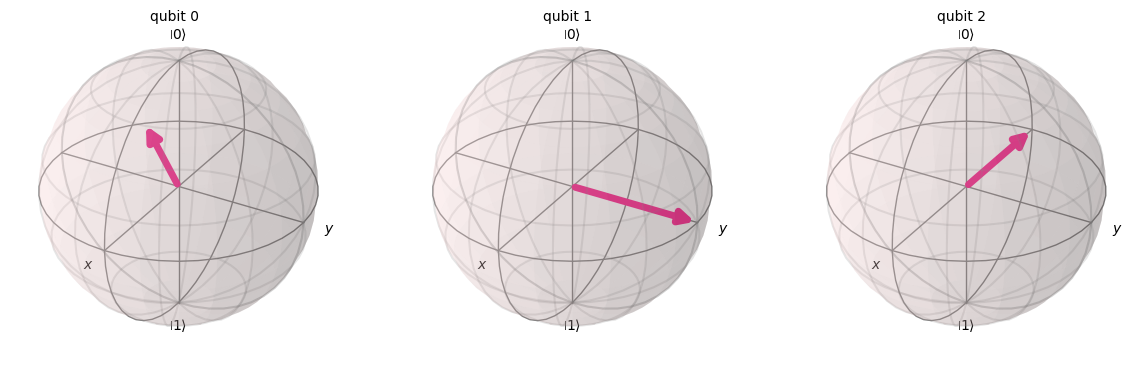

In [46]:
# initiate
estimator = Aer.get_backend('statevector_simulator')

#run
job = estimator.run(qc)

# result
psi = job.result().get_statevector(qc, decimals = 3)

print("\n Quantum state is:" , psi)

plot_bloch_multivector(psi)

### These states are exactly the states that their superposition gives the  fourier transform of |101>. By applying inverse_qft, we get the computational basis, i.e. |101>

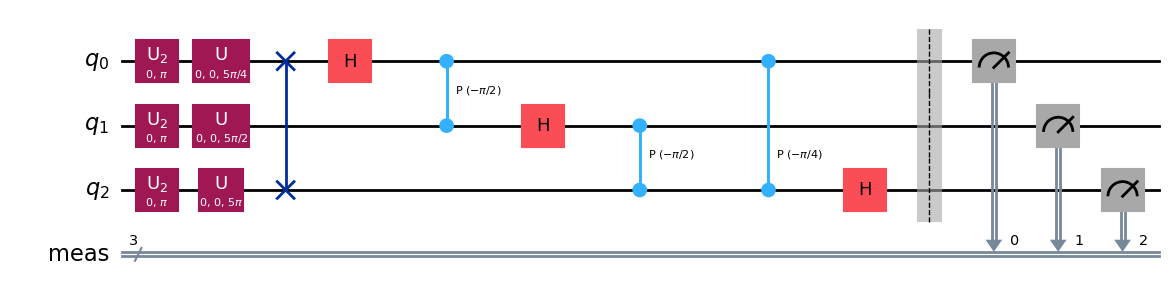

In [47]:
qc = inverse_qft(qc, nqubits)
qc.measure_all()
qc.draw('mpl')


 Total counts are: {'101': 1000}


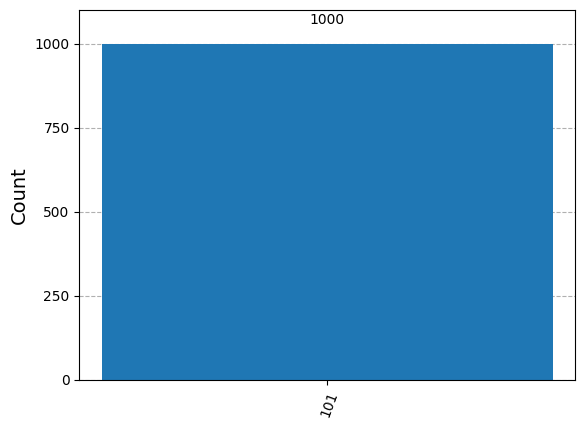

In [48]:
# initiate
estimator = Aer.get_backend('qasm_simulator')

#run
job = estimator.run(qc, shots = 1000)

# result
counts = job.result().get_counts(qc)

print("\n Total counts are:" , counts)

plot_histogram(counts)